In [15]:
!pip install wordcloud

In [16]:
!pip install keras
!pip install tensorflow

In [17]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
# Loads the TSV file into a pandas DataFrame.
def load_data(file_path):
    df = pd.read_csv(file_path, sep='\t', header=None,
                     names=['label','file_name','label_text','statement','topic',
                            'speaker','speaker_job','state','party','barely_true_counts',
                            'false_counts','half_true_counts','mostly_true_counts',
                            'pants_on_fire_counts','venue','extracted_context'])
    return df

In [20]:
# Prints some basic information about the dataset.
def explore_data(df):
    print("Shape of DataFrame:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nNull values:\n",df.isnull().sum())
    print("\nFirst 5 rows:\n", df.head())


In [21]:
# Cleans the input text by removing special characters, lowercasing,
# tokenizing, removing stopwords, and applying lemmatization.
# I took most of it from my 2nd nlp hw
def preprocess_data(data):

    data['statement'] = data['statement'].fillna('')  # Fill empty values as string
    data['statement'] = data['statement'].str.lower()  # Convert to lowercase
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove punctuation
    data['statement'] = data['statement'].apply(lambda x: re.sub(r'\d+', '', x))  # Remove numbers

    # len(word) > 2 might be unncessary. Let's try
    data['statement'] = data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words and len(word) > 2]))  # Remove stopwords
    """
    data['processed_statement'] = data['statement'].apply(lambda x: word_tokenize(x))    # Tokenize

    lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer
    data['processed_statement'] = data['processed_statement'].apply(
        lambda token_list: [lemmatizer.lemmatize(word) for word in token_list])
    """
    return data


In [22]:
# Plots the distribution of labels in the dataset (label_text column).
def plot_label_distribution(df):

    plt.figure(figsize=(8,4))
    sns.countplot(x='label_text', data=df, order=df['label_text'].value_counts().index)
    plt.title('Distribution of Label Text')
    plt.xlabel('Label Text')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [23]:
# Plots the distribution of 'party' column.
def plot_party_distribution(df):

    plt.figure(figsize=(8,4))
    sns.countplot(x='party', data=df, order=df['party'].value_counts().index)
    plt.title('Distribution of Party')
    plt.xlabel('Party')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
# Quite self explanatory name
def plot_top_15_speakers(df):

    top_speakers = df['speaker'].value_counts().head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 15 Speakers by Frequency")
    plt.xlabel("Speaker")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [25]:
# Plots a WordCloud of the most frequently used words in the statements.
def plot_wordcloud(df, column='statement'):

    text = " ".join(df[column].dropna().values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [26]:
def plot_top_4_speakers_label_distribution(df):
    # Get top 4 speakers by number of statements
    top_4_speakers = df['speaker'].value_counts().head(4).index

    # Filter rows for top 4 speakers
    df_top_4 = df[df['speaker'].isin(top_4_speakers)]

    # Group by
    group_df = df_top_4.groupby(['speaker', 'label_text']).size().reset_index(name='count')

    # Create pivot table
    pivot_table = group_df.pivot(index='speaker', columns='label_text', values='count').fillna(0)

    # Reorder columns from most true to most false
    ordered_labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
    pivot_table = pivot_table[ordered_labels]

    # Plot settings
    plt.figure(figsize=(10, 6))

    pivot_table.plot(kind='bar', stacked=False, ax=plt.gca())

    plt.title("Label Distribution for Top 4 Speakers")
    plt.xlabel("Speaker")
    plt.ylabel("Count of Labels")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [27]:
# Correlation of most used words and labels
def plot_word_label_correlation(df):
    # Get most common words
    all_words = [word for statement in df['processed_statement'] for word in statement]
    word_freq = pd.Series(all_words).value_counts()
    top_words = word_freq.head(15).index.tolist()

    # Create word presence matrix
    word_matrices = []
    for word in top_words:
        word_matrices.append(df['processed_statement'].apply(lambda x: word in x).astype(int))

    word_df = pd.concat(word_matrices, axis=1)
    word_df.columns = top_words

    # Calculate correlations
    label_dummies = pd.get_dummies(df['label_text'])
    correlation_matrix = pd.DataFrame()
    ordered_labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

    for label in ordered_labels:
        correlation_matrix[label] = word_df.corrwith(label_dummies[label])

    # Plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_matrix.T,
                cmap='Blues',
                annot=True,
                fmt='.2f',
                xticklabels=top_words,
                yticklabels=ordered_labels,
                cbar_kws={'label': ''})

    plt.title('Token-Label Distribution')
    plt.xlabel('Token')
    plt.ylabel('Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [28]:
train_df = load_data('train2.tsv')
val_df = load_data('val2.tsv')
test_df = load_data('test2.tsv')

print("\n--------------------------  Attention! Training dataset incoming!  ---------------------------\n")
explore_data(train_df)
print("\n--------------------------  Attention! Validation dataset incoming!  ---------------------------\n")
explore_data(val_df)
print("\n--------------------------  Attention! Test dataset incoming!  ---------------------------\n")
explore_data(test_df)


--------------------------  Attention! Training dataset incoming!  ---------------------------

Shape of DataFrame: (10240, 16)

Data Types:
 label                     int64
file_name                object
label_text               object
statement                object
topic                    object
speaker                  object
speaker_job              object
state                    object
party                    object
barely_true_counts      float64
false_counts            float64
half_true_counts        float64
mostly_true_counts      float64
pants_on_fire_counts    float64
venue                    object
extracted_context        object
dtype: object

Null values:
 label                      0
file_name                  0
label_text                 0
statement                  0
topic                      2
speaker                    2
speaker_job             2898
state                   2210
party                      2
barely_true_counts         2
false_counts              

In [29]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def label_encode_columns(df, columns):
    """
    Label encodes the specified columns in a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to be encoded.
        columns (list): List of column names to be label encoded.

    Returns:
        pd.DataFrame: The DataFrame with label-encoded columns.
        dict: A dictionary of LabelEncoders for each column.
    """
    label_encoders = {}

    for col in columns:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        else:
            print(f"Column '{col}' not found in DataFrame.")

    return df, label_encoders


In [30]:
# There are 2 null values for speaker in the training data. Here we drop them
print("Before: ", train_df['speaker'].isnull().sum())
train_df = train_df.dropna(subset=['speaker'])
print("After: ", train_df['speaker'].isnull().sum())

Before:  2
After:  0


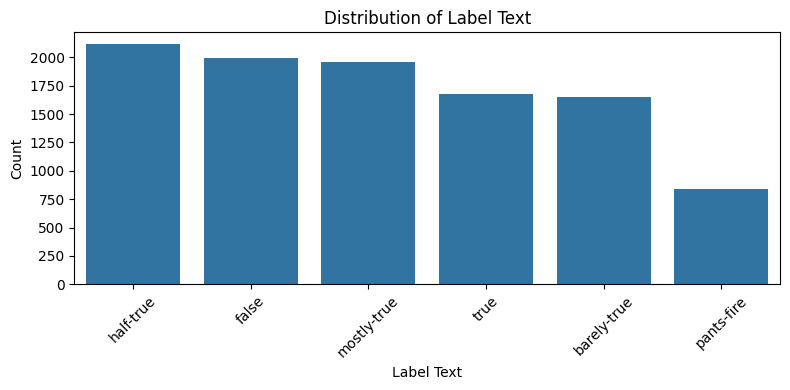

In [31]:
plot_label_distribution(train_df)

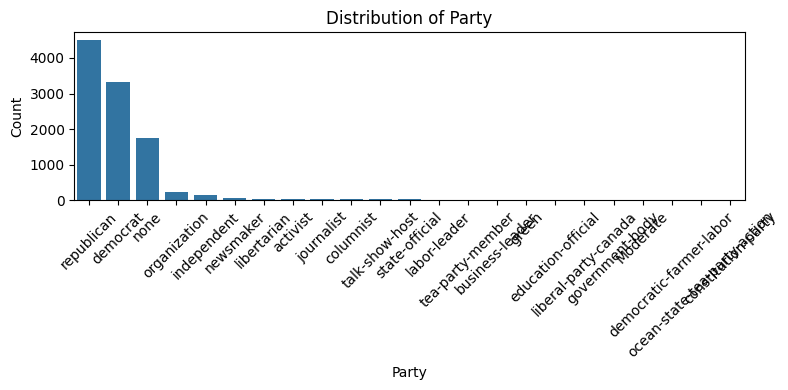

In [32]:
plot_party_distribution(train_df)

<ipython-input-24-9955f1f81154>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")


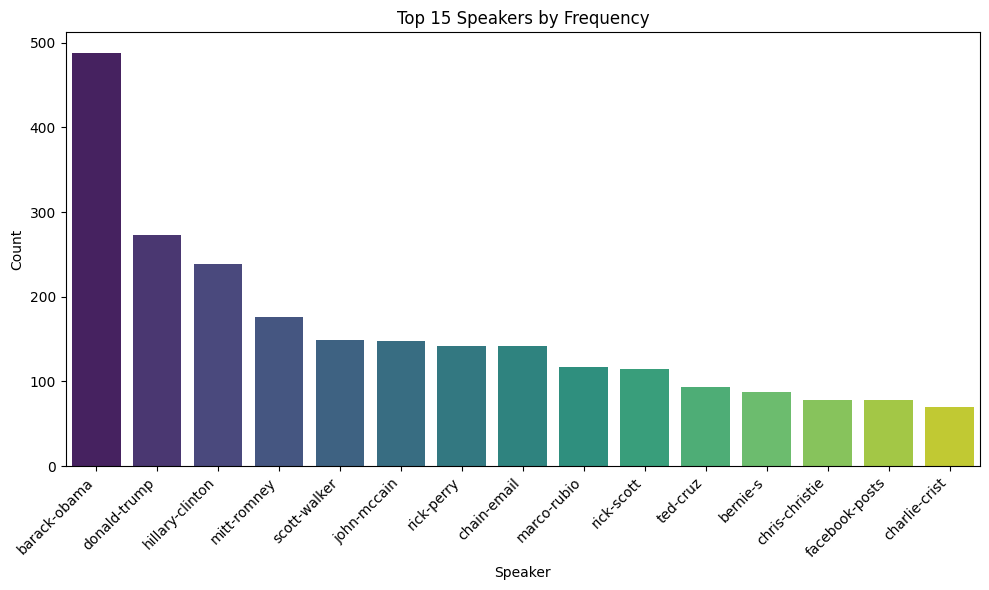

In [33]:
plot_top_15_speakers(train_df)

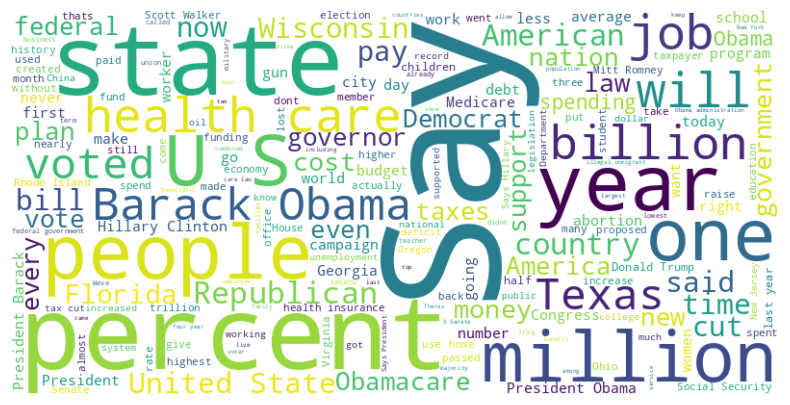

In [34]:
plot_wordcloud(train_df)

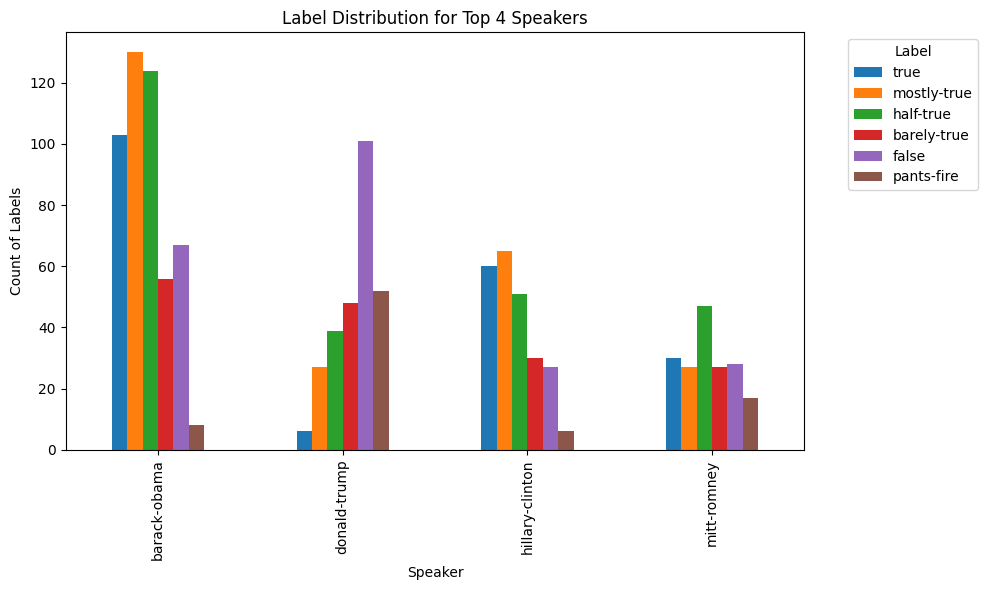

In [35]:
plot_top_4_speakers_label_distribution(train_df)

In [36]:
# Text preprocessing:
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)
train_df["statement"]


,statement
0,says annies list political group supports thir...
1,decline coal start started natural gas took st...
2,hillary clinton agrees john mccain voting give...
3,health care reform legislation likely mandate ...
4,economic turnaround started end term
...,...
10235,larger number shark attacks florida cases vote...
10236,democrats become party atlanta metro area blacks
10237,says alternative social security operates galv...
10238,lifting cuban embargo allowing travel cuba


In [37]:
#plot_word_label_correlation(train_df)

In [38]:
train_df.head()

,label,file_name,label_text,statement,topic,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,venue,extracted_context
0,0,2635.json,false,says annies list political group supports thir...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,1,10540.json,half-true,decline coal start started natural gas took st...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,2,324.json,mostly-true,hillary clinton agrees john mccain voting give...,foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,3,1123.json,false,health care reform legislation likely mandate ...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,4,9028.json,half-true,economic turnaround started end term,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label_text'])


In [40]:
train_df,_=label_encode_columns(train_df, ['topic', 'speaker', 'speaker_job', 'state', 'party','venue'])
train_df.drop(['extracted_context','label','label_text','file_name', 'extracted_context'], axis=1, inplace=True)


In [41]:
train_df.head()

,statement,topic,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,venue,label_encoded
0,says annies list political group supports thir...,30,814,868,61,19,0.0,1.0,0.0,0.0,0.0,1313,1
1,decline coal start started natural gas took st...,2570,2491,866,68,5,0.0,0.0,1.0,1.0,0.0,1153,2
2,hillary clinton agrees john mccain voting give...,2863,182,641,19,5,70.0,71.0,160.0,163.0,9.0,79,3
3,health care reform legislation likely mandate ...,3075,272,1097,81,16,7.0,19.0,3.0,5.0,44.0,1403,1
4,economic turnaround started end term,2182,428,1097,13,5,15.0,9.0,20.0,19.0,2.0,2877,2


In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [43]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# BERT Tokenizer ve Modeli Yükleme
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


# One-hot encoding of labels
num_classes = 6
labels_one_hot = tf.keras.utils.to_categorical(train_df['label_encoded'], num_classes=num_classes)

# Veriyi eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(train_df, labels_one_hot, test_size=0.2, random_state=42)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
train_df

,statement,topic,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,venue,label_encoded
0,says annies list political group supports thir...,30,814,868,61,19,0.0,1.0,0.0,0.0,0.0,1313,1
1,decline coal start started natural gas took st...,2570,2491,866,68,5,0.0,0.0,1.0,1.0,0.0,1153,2
2,hillary clinton agrees john mccain voting give...,2863,182,641,19,5,70.0,71.0,160.0,163.0,9.0,79,3
3,health care reform legislation likely mandate ...,3075,272,1097,81,16,7.0,19.0,3.0,5.0,44.0,1403,1
4,economic turnaround started end term,2182,428,1097,13,5,15.0,9.0,20.0,19.0,2.0,2877,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,larger number shark attacks florida cases vote...,243,12,1097,13,16,0.0,1.0,1.0,1.0,0.0,3876,3
10236,democrats become party atlanta metro area blacks,2431,36,1097,15,19,0.0,0.0,0.0,1.0,0.0,2755,3
10237,says alternative social security operates galv...,3721,1108,1097,15,19,4.0,11.0,5.0,3.0,3.0,496,2
10238,lifting cuban embargo allowing travel cuba,2840,1243,1097,13,5,3.0,1.0,3.0,0.0,0.0,2265,1


In [45]:

# BERT ile tokenizasyon
max_len = 20  # Maksimum sekans uzunluğu
with tf.device('/GPU:0'):  # GPU'da çalışmayı zorunlu kıl
    train_tokens = tokenizer(X_train['statement'].tolist(), padding=True, truncation=True, return_tensors="tf", max_length=max_len)
    test_tokens = tokenizer(X_test['statement'].tolist(), padding=True, truncation=True, return_tensors="tf", max_length=max_len)

    # BERT'den embedding çıkarma
    bert_train_embeddings = bert_model(train_tokens)["last_hidden_state"]
    bert_test_embeddings = bert_model(test_tokens)["last_hidden_state"]

# Embedding boyutlarını kontrol et
print("Train Embeddings Shape:", bert_train_embeddings.shape)
print("Test Embeddings Shape:", bert_test_embeddings.shape)

Train Embeddings Shape: (8190, 20, 768)
Test Embeddings Shape: (2048, 20, 768)


In [46]:

# CNN Modeli
cnn_input = tf.keras.layers.Input(shape=(max_len, 768))  # 768: BERT embedding boyutu
conv = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu")(cnn_input)
pooling = tf.keras.layers.GlobalMaxPooling1D()(conv)
dense = tf.keras.layers.Dense(64, activation="relu")(pooling)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(dense)

cnn_model = tf.keras.models.Model(inputs=cnn_input, outputs=output)

# Modeli derle
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Modeli fit et
cnn_model.fit(bert_train_embeddings, y_train, epochs=5, batch_size=2, validation_data=(bert_test_embeddings, y_test))

# Accuracy Değerini Görüntüle
train_loss, train_accuracy = cnn_model.evaluate(bert_train_embeddings, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")
test_loss, test_accuracy = cnn_model.evaluate(bert_test_embeddings, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/5
4095/4095 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.2018 - loss: 1.8098 - val_accuracy: 0.1992 - val_loss: 1.7930
Epoch 2/5
4095/4095 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.2159 - loss: 1.7377 - val_accuracy: 0.2271 - val_loss: 1.7202
Epoch 3/5
4095/4095 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2462 - loss: 1.7092 - val_accuracy: 0.2344 - val_loss: 1.7470
Epoch 4/5
4095/4095 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.2795 - loss: 1.6568 - val_accuracy: 0.2275 - val_loss: 1.7409
Epoch 5/5
4095/4095 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.3070 - loss: 1.5712 - val_accuracy: 0.2197 - val_loss: 1.8169
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3964 - loss: 1.4356
Train Accuracy: 0.3894
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1964 - loss: 1.8370
Test Accuracy: 0.2197


In [47]:
# Enhanced CNN Model
cnn_input = tf.keras.layers.Input(shape=(max_len, 768))  # Input from BERT embeddings

# Multi-scale convolutional layers
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(cnn_input)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(cnn_input)
conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same")(cnn_input)

# Combine convolutional outputs
concat = tf.keras.layers.Concatenate()([conv1, conv2, conv3])

# Batch normalization
batch_norm = tf.keras.layers.BatchNormalization()(concat)

# Pooling layers
max_pooling = tf.keras.layers.GlobalMaxPooling1D()(batch_norm)
avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(batch_norm)
pooling = tf.keras.layers.Concatenate()([max_pooling, avg_pooling])

# Dense layers with dropout
dense = tf.keras.layers.Dense(128, activation="relu")(pooling)
dropout = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(6, activation="softmax")(dropout)  # Adjust for number of classes

# Compile the model
cnn_model = tf.keras.models.Model(inputs=cnn_input, outputs=output)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
cnn_model.fit(
    bert_train_embeddings, y_train,
    validation_data=(bert_test_embeddings, y_test),
    epochs=7,
    batch_size=8,
)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(bert_test_embeddings, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.1799 - loss: 2.2729 - val_accuracy: 0.2300 - val_loss: 1.7499
Epoch 2/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.2325 - loss: 1.7410 - val_accuracy: 0.2305 - val_loss: 1.7458
Epoch 3/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.2567 - loss: 1.7011 - val_accuracy: 0.2354 - val_loss: 1.7359
Epoch 4/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2859 - loss: 1.6570 - val_accuracy: 0.2236 - val_loss: 1.7498
Epoch 5/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3277 - loss: 1.6023 - val_accuracy: 0.2393 - val_loss: 1.7570
Epoch 6/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3545 - loss: 1.5452 - val_accuracy: 0.2158 - val_loss: 1.7913
Epoch 7/7
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4182 - loss: 1.4404 - val_accuracy: 0.2256 - val_loss: 1.8045
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2232 - loss: 1.8047
Test Accuracy: 0.2256

In [48]:
metadata_train=X_train.drop(['statement','label_encoded'],axis=1).to_numpy()
metadata_test=X_test.drop(['statement','label_encoded'],axis=1).to_numpy()

print(metadata_train.shape)
print(metadata_test.shape)

(8190, 11)
(2048, 11)


In [49]:
metadata_train = tf.convert_to_tensor(metadata_train, dtype=tf.float32)
metadata_test = tf.convert_to_tensor(metadata_test, dtype=tf.float32)

In [50]:
# Define inputs
text_input = tf.keras.layers.Input(shape=(max_len, 768), name="text_input")
metadata_input = tf.keras.layers.Input(shape=(11,), name="metadata_input")

# Process text input
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(text_input)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(text_input)
conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same")(text_input)

# Combine text features
text_concat = tf.keras.layers.Concatenate()([conv1, conv2, conv3])
text_batch_norm = tf.keras.layers.BatchNormalization()(text_concat)
text_max_pooling = tf.keras.layers.GlobalMaxPooling1D()(text_batch_norm)
text_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(text_batch_norm)
text_features = tf.keras.layers.Concatenate()([text_max_pooling, text_avg_pooling])

# Process metadata separately
metadata_dense = tf.keras.layers.Dense(32, activation="relu")(metadata_input)
metadata_batch_norm = tf.keras.layers.BatchNormalization()(metadata_dense)

# Combine features after processing them separately
combined = tf.keras.layers.Concatenate()([text_features, metadata_batch_norm])

# Final layers
dense = tf.keras.layers.Dense(128, activation="relu")(combined)
dropout = tf.keras.layers.Dropout(0.5)(dense)
output = tf.keras.layers.Dense(6, activation="softmax")(dropout)

# Create model with both inputs
cnn_model = tf.keras.models.Model(
    inputs={"text_input": text_input, "metadata_input": metadata_input},
    outputs=output
)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
cnn_model.fit(
    x={"text_input": bert_train_embeddings, "metadata_input": metadata_train},  # Match input names
    y=y_train,
    validation_data=(
        {"text_input": bert_test_embeddings, "metadata_input": metadata_test},
        y_test
    ),
    epochs=5,
    batch_size=8,
)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(
    {"text_input": bert_test_embeddings, "metadata_input": metadata_test}, y_test
)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.1903 - loss: 2.2823 - val_accuracy: 0.2334 - val_loss: 1.7634
Epoch 2/5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.2479 - loss: 1.7295 - val_accuracy: 0.2036 - val_loss: 1.7674
Epoch 3/5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2757 - loss: 1.7025 - val_accuracy: 0.2363 - val_loss: 1.7746
Epoch 4/5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2931 - loss: 1.6556 - val_accuracy: 0.2261 - val_loss: 1.7347
Epoch 5/5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3162 - loss: 1.6184 - val_accuracy: 0.2412 - val_loss: 1.7820
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2358 - loss: 1.7905
Test Accuracy: 0.2412


In [51]:
import tensorflow as tf

# Define inputs
text_input = tf.keras.layers.Input(shape=(max_len, 768), name="text_input")
metadata_input = tf.keras.layers.Input(shape=(11,), name="metadata_input")

# Process text input with multi-scale CNN
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="same")(text_input)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation="relu", padding="same")(text_input)
conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same")(text_input)
conv4 = tf.keras.layers.Conv1D(filters=128, kernel_size=9, activation="relu", padding="same")(text_input)

# Combine text features with residual connection
text_concat = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4])
text_concat_resized = tf.keras.layers.Conv1D(filters=768, kernel_size=1, activation="linear", padding="same")(text_concat)
text_residual = tf.keras.layers.Add()([text_input, text_concat_resized])

text_batch_norm = tf.keras.layers.BatchNormalization()(text_residual)
text_max_pooling = tf.keras.layers.GlobalMaxPooling1D()(text_batch_norm)
text_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(text_batch_norm)
text_features = tf.keras.layers.Concatenate()([text_max_pooling, text_avg_pooling])

# Process metadata with matching dimensions
metadata_dense1 = tf.keras.layers.Dense(256, activation="relu")(metadata_input)
metadata_dense2 = tf.keras.layers.Dense(1536, activation="relu")(metadata_dense1)  # Match text_features dimension
metadata_batch_norm = tf.keras.layers.BatchNormalization()(metadata_dense2)

# Reshape for attention
text_features_expanded = tf.keras.layers.Reshape((1, 1536))(text_features)
metadata_features_expanded = tf.keras.layers.Reshape((1, 1536))(metadata_batch_norm)

# Apply attention
attention = tf.keras.layers.Attention()([text_features_expanded, metadata_features_expanded])
attention_flattened = tf.keras.layers.Flatten()(attention)

# Combine features
combined = tf.keras.layers.Concatenate()([text_features, metadata_batch_norm, attention_flattened])

# Dense layers with dropout
dense1 = tf.keras.layers.Dense(256, activation="relu")(combined)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
output = tf.keras.layers.Dense(6, activation="softmax")(dropout2)

# Create and compile model
cnn_model = tf.keras.models.Model(
    inputs={"text_input": text_input, "metadata_input": metadata_input},
    outputs=output
)

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3
)

# Train model
cnn_model.fit(
    x={"text_input": bert_train_embeddings, "metadata_input": metadata_train},
    y=y_train,
    validation_data=(
        {"text_input": bert_test_embeddings, "metadata_input": metadata_test},
        y_test
    ),
    epochs=25,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
test_loss, test_accuracy = cnn_model.evaluate(
    {"text_input": bert_test_embeddings, "metadata_input": metadata_test},
    y_test
)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1834 - loss: 2.2154

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.1834 - loss: 2.2149 - val_accuracy: 0.2114 - val_loss: 1.7829 - learning_rate: 1.0000e-04
Epoch 2/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2085 - loss: 1.7865 - val_accuracy: 0.2090 - val_loss: 1.7757 - learning_rate: 1.0000e-04
Epoch 3/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1905 - loss: 1.7819 - val_accuracy: 0.2280 - val_loss: 1.7572 - learning_rate: 1.0000e-04
Epoch 4/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.2001 - loss: 1.7676 - val_accuracy: 0.2197 - val_loss: 1.7666 - learning_rate: 1.0000e-04
Epoch 5/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.2015 - loss: 1.7613 - val_accuracy: 0.2056 - val_loss: 1.7602 - learning_rate: 1.0000e-04
Epoch 6/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.2073 - loss: 1.7618 - val_accuracy: 0.2290 - val_loss: 1.7424 - learning_rate: 1.0000e-04
Epoch 7/25
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.21

In [52]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Veri normalizasyonu
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_test_scaled = scaler.transform(metadata_test)

# BERT embeddings normalizasyonu
bert_train_norm = tf.keras.utils.normalize(bert_train_embeddings, axis=-1)
bert_test_norm = tf.keras.utils.normalize(bert_test_embeddings, axis=-1)

# Model tanımı
text_input = tf.keras.layers.Input(shape=(max_len, 768), name="text_input")
metadata_input = tf.keras.layers.Input(shape=(11,), name="metadata_input")

# Text processing with deeper CNN
conv1 = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same")(text_input)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same")(conv1)
conv1 = tf.keras.layers.BatchNormalization()(conv1)

conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation="relu", padding="same")(text_input)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation="relu", padding="same")(conv2)
conv2 = tf.keras.layers.BatchNormalization()(conv2)

conv3 = tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(text_input)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(conv3)
conv3 = tf.keras.layers.BatchNormalization()(conv3)

# Combine text features
text_concat = tf.keras.layers.Concatenate()([conv1, conv2, conv3])
text_spatial_dropout = tf.keras.layers.SpatialDropout1D(0.3)(text_concat)

# Residual connection
text_conv_reduced = tf.keras.layers.Conv1D(filters=768, kernel_size=1, activation="linear")(text_spatial_dropout)
text_residual = tf.keras.layers.Add()([text_input, text_conv_reduced])
text_batch_norm = tf.keras.layers.BatchNormalization()(text_residual)

# Pooling operations
text_max_pool = tf.keras.layers.GlobalMaxPooling1D()(text_batch_norm)
text_avg_pool = tf.keras.layers.GlobalAveragePooling1D()(text_batch_norm)
text_features = tf.keras.layers.Concatenate()([text_max_pool, text_avg_pool])

# Metadata processing
metadata_dense1 = tf.keras.layers.Dense(256, activation="relu")(metadata_input)
metadata_bn1 = tf.keras.layers.BatchNormalization()(metadata_dense1)
metadata_dense2 = tf.keras.layers.Dense(512, activation="relu")(metadata_bn1)
metadata_bn2 = tf.keras.layers.BatchNormalization()(metadata_dense2)

# Attention mechanism
text_attention = tf.keras.layers.Reshape((1, 1536))(text_features)
metadata_attention = tf.keras.layers.Dense(1536, activation="relu")(metadata_bn2)
metadata_attention = tf.keras.layers.Reshape((1, 1536))(metadata_attention)

attention = tf.keras.layers.Attention()([text_attention, metadata_attention])
attention_flat = tf.keras.layers.Flatten()(attention)

# Combine all features
combined = tf.keras.layers.Concatenate()([text_features, metadata_bn2, attention_flat])

# Dense layers with L2 regularization and batch normalization
dense1 = tf.keras.layers.Dense(
    384,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(combined)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.Dropout(0.6)(dense1)

dense2 = tf.keras.layers.Dense(
    192,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
dense2 = tf.keras.layers.Dropout(0.5)(dense2)

dense3 = tf.keras.layers.Dense(
    96,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(dense2)
dense3 = tf.keras.layers.BatchNormalization()(dense3)
dense3 = tf.keras.layers.Dropout(0.4)(dense3)

# Output layer
output = tf.keras.layers.Dense(6, activation="softmax")(dense3)

# Create model
cnn_model = tf.keras.models.Model(
    inputs={"text_input": text_input, "metadata_input": metadata_input},
    outputs=output
)

# Optimizer with AMSGrad
optimizer = tf.keras.optimizers.Adam(
    learning_rate=5e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True
)

# Compile model
cnn_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train model
history = cnn_model.fit(
    x={
        "text_input": bert_train_norm,
        "metadata_input": metadata_train_scaled
    },
    y=y_train,
    validation_data=(
        {
            "text_input": bert_test_norm,
            "metadata_input": metadata_test_scaled
        },
        y_test
    ),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = cnn_model.evaluate(
    {
        "text_input": bert_test_norm,
        "metadata_input": metadata_test_scaled
    },
    y_test
)


print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1778 - loss: 18.3241

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Epoch 1: val_loss improved from inf to 9.08009, saving model to best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 76ms/step - accuracy: 0.1778 - loss: 18.3170 - val_accuracy: 0.2275 - val_loss: 9.0801 - learning_rate: 5.0000e-04
Epoch 2/30
509/512 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2054 - loss: 8.0839
Epoch 2: val_loss improved from 9.08009 to 5.16308, saving model to best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2054 - loss: 8.0757 - val_accuracy: 0.2256 - val_loss: 5.1631 - learning_rate: 5.0000e-04
Epoch 3/30
509/512 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2049 - loss: 4.8433
Epoch 3: val_loss improved from 5.16308 to 3.62688, saving model to best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2049 - loss: 4.8401 - val_accuracy: 0.2397 - val_loss: 3.6269 - learning_rate: 5.0000e-04
Epoch 4/30
511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2177 - loss: 3.4858
Epoch 4: val_loss improved from 3.62688 to 2.8

In [62]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Veri normalizasyonu
scaler = StandardScaler()
metadata_train_scaled = scaler.fit_transform(metadata_train)
metadata_test_scaled = scaler.transform(metadata_test)

# BERT embeddings normalizasyonu
bert_train_norm = tf.keras.utils.normalize(bert_train_embeddings, axis=-1)
bert_test_norm = tf.keras.utils.normalize(bert_test_embeddings, axis=-1)

# Model tanımı
text_input = tf.keras.layers.Input(shape=(max_len, 768), name="text_input")
metadata_input = tf.keras.layers.Input(shape=(11,), name="metadata_input")

# Text processing with deeper CNN
conv1 = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same")(text_input)
conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation="relu", padding="same")(conv1)
conv1 = tf.keras.layers.BatchNormalization()(conv1)

conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation="relu", padding="same")(text_input)
conv2 = tf.keras.layers.BatchNormalization()(conv2)
conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation="relu", padding="same")(conv2)
conv2 = tf.keras.layers.BatchNormalization()(conv2)

conv3 = tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(text_input)
conv3 = tf.keras.layers.BatchNormalization()(conv3)
conv3 = tf.keras.layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(conv3)
conv3 = tf.keras.layers.BatchNormalization()(conv3)

# Combine text features
text_concat = tf.keras.layers.Concatenate()([conv1, conv2, conv3])
text_spatial_dropout = tf.keras.layers.SpatialDropout1D(0.3)(text_concat)

# Residual connection
text_conv_reduced = tf.keras.layers.Conv1D(filters=768, kernel_size=1, activation="linear")(text_spatial_dropout)
text_residual = tf.keras.layers.Add()([text_input, text_conv_reduced])
text_batch_norm = tf.keras.layers.BatchNormalization()(text_residual)

# Pooling operations
text_max_pool = tf.keras.layers.GlobalMaxPooling1D()(text_batch_norm)
text_avg_pool = tf.keras.layers.GlobalAveragePooling1D()(text_batch_norm)
text_features = tf.keras.layers.Concatenate()([text_max_pool, text_avg_pool])

# Metadata processing
metadata_dense1 = tf.keras.layers.Dense(256, activation="relu")(metadata_input)
metadata_bn1 = tf.keras.layers.BatchNormalization()(metadata_dense1)
metadata_dense2 = tf.keras.layers.Dense(512, activation="relu")(metadata_bn1)
metadata_bn2 = tf.keras.layers.BatchNormalization()(metadata_dense2)

# Modified attention mechanism with proper reshaping
text_attention = tf.keras.layers.Dense(512, activation="tanh")(text_features)  # Reduce dimensions
metadata_attention = tf.keras.layers.Dense(512, activation="tanh")(metadata_bn2)  # Match dimensions

# Combine features with attention weights
attention_weights = tf.keras.layers.Dot(axes=1)([text_attention, metadata_attention])
attention_weights = tf.keras.layers.Activation('softmax')(attention_weights)

# Apply attention and combine features
attended_features = tf.keras.layers.Multiply()([text_features, attention_weights])
combined = tf.keras.layers.Concatenate()([attended_features, metadata_bn2])

# Dense layers with L2 regularization and batch normalization
dense1 = tf.keras.layers.Dense(
    384,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(combined)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense1 = tf.keras.layers.Dropout(0.6)(dense1)

dense2 = tf.keras.layers.Dense(
    192,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
dense2 = tf.keras.layers.Dropout(0.5)(dense2)

dense3 = tf.keras.layers.Dense(
    96,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(0.02)
)(dense2)
dense3 = tf.keras.layers.BatchNormalization()(dense3)
dense3 = tf.keras.layers.Dropout(0.4)(dense3)

# Output layer
output = tf.keras.layers.Dense(6, activation="softmax")(dense3)

# Create model
cnn_model = tf.keras.models.Model(
    inputs={"text_input": text_input, "metadata_input": metadata_input},
    outputs=output
)

# Optimizer with AMSGrad
optimizer = tf.keras.optimizers.Adam(
    learning_rate=7e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True
)

# Compile model
cnn_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)


# Train model
history = cnn_model.fit(
    x={
        "text_input": bert_train_norm,
        "metadata_input": metadata_train_scaled
    },
    y=y_train,
    validation_data=(
        {
            "text_input": bert_test_norm,
            "metadata_input": metadata_test_scaled
        },
        y_test
    ),
    epochs=40,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

# Evaluate model
test_loss, test_accuracy = cnn_model.evaluate(
    {
        "text_input": bert_test_norm,
        "metadata_input": metadata_test_scaled
    },
    y_test,
    verbose=1
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Tahminler
predictions = cnn_model.predict(
    {
        "text_input": bert_test_norm,
        "metadata_input": metadata_test_scaled
    }
)

# Model performans metrikleri
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Tahminleri sınıf etiketlerine dönüştür
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_pred)
# Sınıflandırma raporu
print("\nClassification Report:")
print(classification_report(y_true, y_pred))



Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1643 - loss: 22.7381

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (16, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.19385, saving model to best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.1643 - loss: 22.7369 - val_accuracy: 0.1938 - val_loss: 20.4212 - learning_rate: 7.0000e-05
Epoch 2/40
509/512 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1925 - loss: 20.6379
Epoch 2: val_accuracy improved from 0.19385 to 0.22363, saving model to best_model.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.1925 - loss: 20.6345 - val_accuracy: 0.2236 - val_loss: 18.8531 - learning_rate: 7.0000e-05
Epoch 3/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1906 - loss: 19.0585
Epoch 3: val_accuracy did not improve from 0.22363
512/512 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1906 - loss: 19.0578 - val_accuracy: 0.2158 - val_loss: 17.5406 - learning_rate: 7.0000e-05
Epoch 4/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2058 - loss: 17.6399
Epoch 4: val_accuracy improved from 0.22363 to 0.22852, saving 

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[1 4 2 ... 0 3 1]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.09      0.13       360
           1       0.26      0.47      0.33       364
           2       0.27      0.26      0.26       450
           3       0.28      0.40      0.33       405
           4       0.51      0.21      0.30       138
           5       0.22      0.11      0.15       331

    accuracy                           0.27      2048
   macro avg       0.29      0.26      0.25      2048
weighted avg       0.27      0.27      0.25      2048



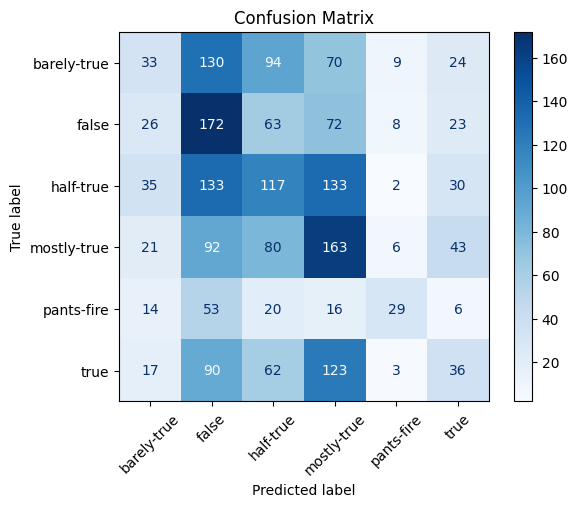

In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Confusion matrix

cm=confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
